data type: <class 'numpy.ndarray'>
data shape: (2000, 8192)
inspecting row 1223: [ 3.97232387  2.84726103  3.59970112 ...  2.39499278  0.83362131
 -1.89156282]
mid row value: -154.71091051258736
data columns: 8192
   Unnamed: 0    event_time ifo   peak_time  peak_time_ns  start_time  \
0      403353  1.261942e+09  L1  1261941530     957031011  1261941530   
1      298687  1.251982e+09  L1  1251982056     995116949  1251982056   
2      283728  1.248640e+09  L1  1248640098     746093034  1248640098   
3      203867  1.243418e+09  L1  1243418038     441406011  1243418038   
4      359761  1.267482e+09  L1  1267481673     359375000  1267481673   

   start_time_ns  duration  peak_frequency  central_freq  ...         Tomte  \
0      875000000   0.18750       39.789299     51.306911  ...  1.368267e-01   
1      988281011   0.01172     1229.363159   1217.868530  ...  1.912738e-04   
2      687500000   0.12500       39.789299     56.314560  ...  1.692398e-02   
3      250000000   0.37500     

/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/gwpy/types/series.py:991: UserWarning: TimeSeries.crop given end larger than current end, crop will begin when the Series actually ends.
  warn(


succesfully loaded Deepextractor model from /home/kfang/gwsim/glitchstream/glitchstream/deepextractor/checkpoints/DeepExtractor_257/checkpoint_best_real_noise_base.pth.tar 
succesfully loaded scaler from /home/kfang/gwsim/glitchstream/glitchstream/deepextractor/checkpoints/scaler.pkl 


/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


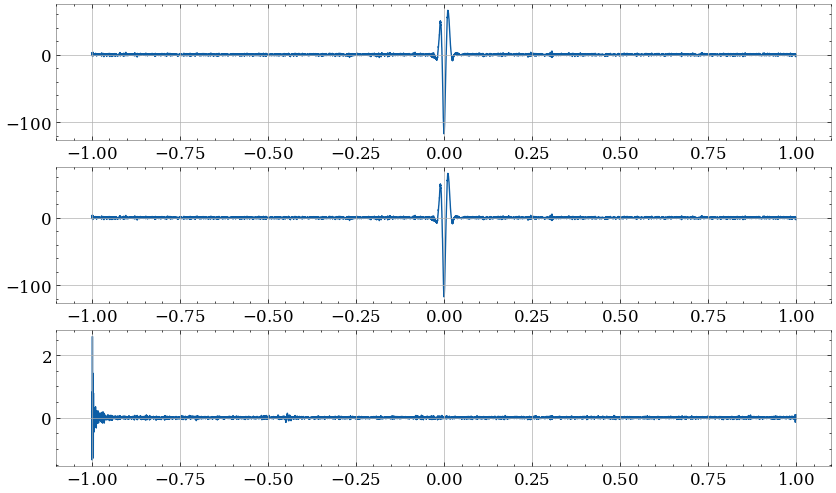

In [ ]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt

from glitchstream.glitch_downloader import GlitchDownloader
from glitchstream.deepextractor import DeepExtractor

base_dir = pathlib.Path('./sample_glitches')

data = np.concatenate([np.load(base_dir / 'random_glitches_all_classes_0_g_hats.npy',allow_pickle=True),np.load(base_dir / 'random_glitches_all_classes_1_g_hats.npy',allow_pickle=True)])

print(f"data type: {type(data)}")
print(f"data shape: {data.shape}")

randrow = np.random.randint(0, data.shape[0]-1)
print(f"inspecting row {randrow}: {data[randrow]}")
print(f"mid row value: {data[randrow][data.shape[1]//2]}")
print(f"data columns: {data.shape[1]}")

metadatas = []
metadata_0 = pd.read_csv(base_dir / 'random_glitches_all_classes_0_metadataframe.csv')
metadata_1 = pd.read_csv(base_dir / 'random_glitches_all_classes_1_metadataframe.csv')
metadatas.append(metadata_0)
metadatas.append(metadata_1)
metadatas_df = pd.DataFrame(pd.concat(metadatas, ignore_index=True))

print(metadata_0.head())
entry_1 = metadata_0.iloc[0]
print(f"entry 1 glitch type: {entry_1['ml_label']}")

print("testing if ghat from .npy corresponds to metadata entry")
#randrow = np.random.randint(0, data.shape[0])
print("fixing row number 1887")
randrow = 1887
ghat_1 = data[randrow]

glitch_downloader = GlitchDownloader()
gps_time = metadatas_df.iloc[randrow]['event_time']
ifo = metadatas_df.iloc[randrow]['ifo']

psd,glitch_timeseries,glitch = glitch_downloader.get_glitch(gps_time=gps_time, ifo=ifo)
deepextractor = DeepExtractor()
ghat_2,n_hat_2 = deepextractor(glitch)

t = np.linspace(-1, 1, num=8192)

fig, axs = plt.subplots(3,1, figsize=(10,6))
axs[0].plot(t, ghat_1)
axs[1].plot(t, ghat_2)
axs[2].plot(t, ghat_1 - ghat_2)
plt.show()

In [184]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

X_raw = data
X_normalized = normalize(X_raw,axis=1,norm='l2')

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_normalized)

print(f"shape of data after PCA: {X_pca.shape}")

shape of data after PCA: (2000, 10)


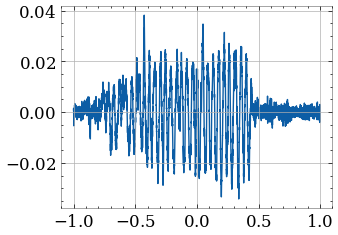

1.0000000000000002


In [200]:
randrow = np.random.randint(0,X_normalized.shape[0] -1)
t = np.linspace(-1,1,8192)

plt.plot(t,X_normalized[randrow])
plt.show()
print(sum(X_normalized[randrow]**2))

In [171]:
pca.explained_variance_ratio_[0:5]

array([0.13285435, 0.08382104, 0.0461309 , 0.03216324,
       0.02652655])

In [161]:
X_reconstructed = pca.inverse_transform(X_pca)
loss = np.mean((X_normalized - X_reconstructed) ** 2)
print(loss)

7.967188250252655e-06


/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(


number of clusters: 7
noise points: 1259


/home/kfang/gwsim/glitchstream/.gwsimenv/lib/python3.11/site-packages/gwpy/plot/axes.py:571: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  return super().legend(*args, **kwargs)


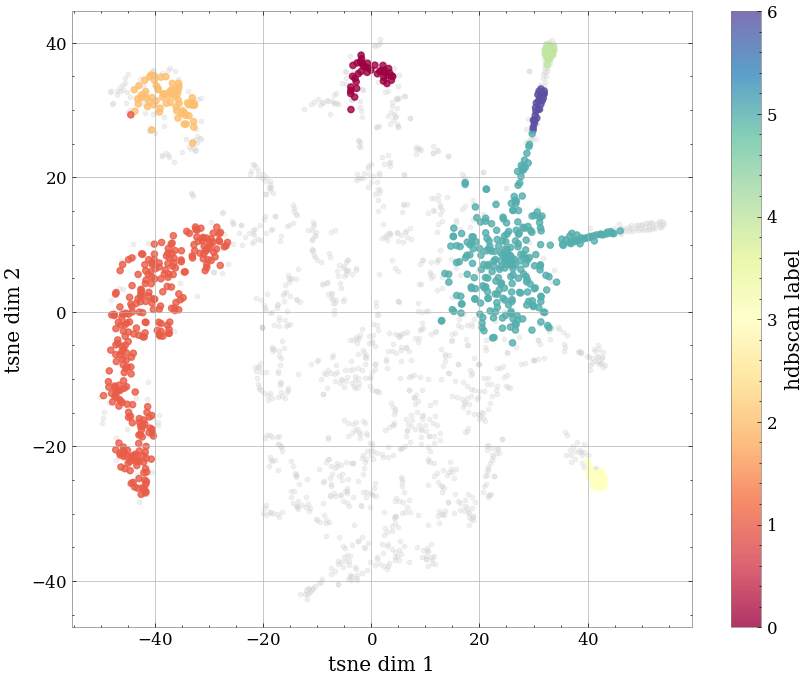

In [211]:
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE

hdbscan = HDBSCAN(min_cluster_size=10)
y_labels_hdbscan = hdbscan.fit_predict(X_pca)

n_clusters = len(set(y_labels_hdbscan)) - (1 if -1 in y_labels_hdbscan else 0)
n_noise = list(y_labels_hdbscan).count(-1)

print(f"number of clusters: {n_clusters}")
print(f"noise points: {n_noise}")

tsne = TSNE(n_components=2,perplexity=30,random_state=42)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10,8))
noise_mask = y_labels_hdbscan == -1
plt.scatter(X_tsne[noise_mask,0],X_tsne[noise_mask,1],c='lightgray',s=10,alpha=0.3)

cluster_mask = ~noise_mask
scatter = plt.scatter(X_tsne[cluster_mask,0],X_tsne[cluster_mask,1],c=y_labels_hdbscan[cluster_mask],cmap='Spectral',s=20,alpha=0.8)
plt.xlabel('tsne dim 1')
plt.ylabel('tsne dim 2')
plt.colorbar(scatter,label='hdbscan label')
plt.legend()
plt.show()

